In [3]:
import QuantLib as ql
from matplotlib import pyplot as plt
import numpy as np
import math

%matplotlib inline

# Overview of the Heston LSV pricing models in Quantlib

Quantlib comes with two pricing engines for a Local Stochastic Volatility extension of the Heston Model, one based on a Finite Difference technique and the other using Monte Carlo Simulation.  The logic for pricing under these model lives in `hestonlsvfdmodel` and `hestonlsvmcmodel`[1] respectively.  Both engines have been implemented by Klaus Spanderden and documented in his blog [2, 3].  In this post I try to describe the logic of these pricing engines in my own words and using plots and code for demonstration purposes.

# Overview of the Heston LVS Model.

The Heston LSV is a local stochastic extension of the traditional Heston diffusion process.  The stochastic processes for this model are given below 

$$
\begin{align*}
    d \ln S_t &= \left(r_t - q_t - \frac{1}{2} L(S_t, t) \nu_t\right)dt + L(S_t, t)\sqrt{\nu_t}dW_t^S \\
    d \nu_t &= \kappa (\theta - \nu_t)dt + \eta\sigma \sqrt{\nu_t}dW_t^{\nu} \\
    \rho dt &= dW_t^SdW_t^{\nu}
\end{align*}
$$

For spot $S$, working in log-spot units $X = \ln(S)$.  This is an extension of the traditional stochastic variance Heston process with a local stochastic diffusion coefficient $L(S_t, t)$ known as the `Leverage Function`.  This is actually an 2-D surface in the spot and time dimensions.  Furthmore the $eta$ value is the `mixing coefficient` which interpolates between a purely stochastic and purely local volatility model.  

By a calculation detailed in Clark [4] and [5], amongst other reference, the Leverage Function satisfies the following relationship  

$$
L(S_t, t) = \frac{\sigma_{LV}(S_t, t)}{\sqrt{\mathbb{E}[\nu_t|S = S_t]}} = \sigma_{LV}(S_t, t)\sqrt{\frac{\int_{\mathbb{R}^+}p(S_t, \nu, t)d\nu}{\int_{\mathbb{R}^+}\nu p(S_t, \nu, t)d\nu}}
$$

where $\sigma_{LV}(S_t, t)$ is the Local Volatility surface defined by Dupire's equation[6].  The principle challenge in working with LSV models is computing the conditional expection values 

$$
\sqrt{\frac{\int_{\mathbb{R}^+}\nu p(S_t, \nu, t)d\nu}{\int_{\mathbb{R}^+} p(S_t, \nu, t)d\nu}}
$$

where $p(S_t, \nu, t)$ is the joint, spot/variance, probability distrubution.  As we discuss below, each pricing engine uses a different numerical technique to approximate these expectation values.

# Overview of the Finite Difference approach to pricing in the Heston LSV.  

As mentioned above, the pricing engine logic contained with the `hestonlsvfdmodel` class implements a finite difference techinique to price intruments using the LSV Heston model.  Specifically, the engine solves the Fokker Planck (aka forward Kolmogorov) equation to determine the time evolution for the probabilty distribution function (pdf).

From the stocastic process for the LSV Heston model defined above, one can derive the Fokker Plank equation as follows (again working log spot units ($X_t = \ln S_t$))

$$
\partial_t p = \frac{1}{2}\partial^2_x\left(L^2\nu p\right) + \frac{1}{2}\eta^2\sigma^2\partial_{\nu}^2\left(\nu \rho\right) + \eta \sigma \partial_x \partial_{\nu} \left(L \nu p\right) \\
            -\partial_x\left((r - q - \frac{1}{2}L^2\nu)p\right) - \partial_{\nu}\left(\kappa(\theta -\nu)p\right)   
$$

subject to the boundary condition 

$$
p(X, \nu, t=0) = \delta (X - X_0) \delta (\nu - \nu_0)
$$
where $\delta(x)$ is a Dirac delta function.  

This boundary condition presents a challenge for the finite difference technique as there is effectively infinite curvature and hence the finite difference approximation breaks down at the origin $(X = X_0, \nu= \nu_0)$.  To ameliorate the situation, quantlib's pricing engine applies a concentrating mesh of discrete points clustered near the origin.

# Mesher Plot

In the code and plot below we show the `concentrating mesher` object for the Heston Local Stochastic Vol model.  These represent the evaluation points used in the variance and spot dimensions.

## Further Topics for Discussion:

1. Boundary Conditions (Zero Flux boundary condition)
2. Computation Domain (variance and spot upper and low quantile estimate s)
3. Stencil/Discretizion Scheme  (Configurable in Quantlib, Default method is Modified Craig Sneyd)
4. Feller Bounds for the Heston diffusions process require special handling to correct/avoid being stuck at the lower bound
5. Sensitivity (Greek) calculations
6. Calibration Stability




Text(0, 0.5, 'variance')

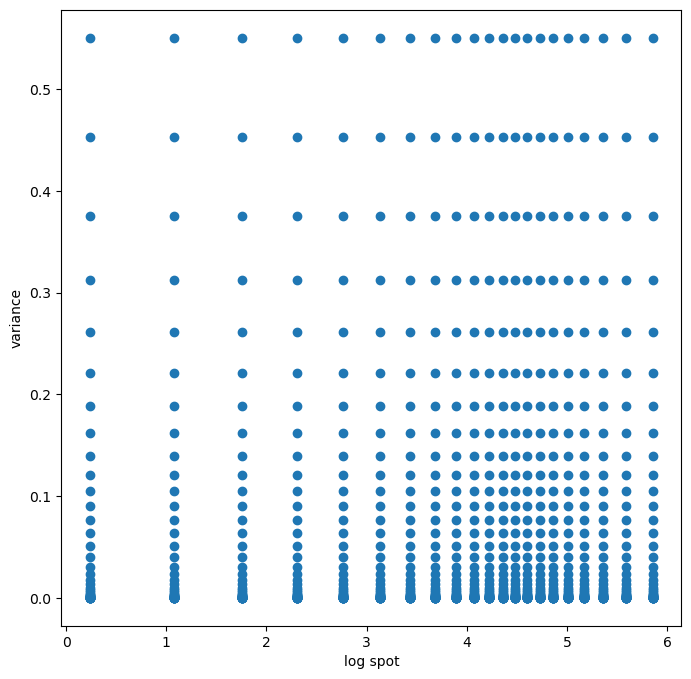

In [5]:
todaysDate = ql.Date(15, ql.May, 2019)
ql.Settings.instance().evaluationDate = todaysDate

settlementDate = todaysDate + ql.Period(2, ql.Days)
exerciseDate = todaysDate + ql.Period(4, ql.Years)

dc = ql.Actual365Fixed()

spot = 100
underlying = ql.QuoteHandle(ql.SimpleQuote(spot))

# assume yeild term structure are flat/constant, in practice calibrate to market quotes
riskFreeRate = ql.YieldTermStructureHandle(ql.FlatForward(settlementDate, 0.05, dc))
dividendYield = ql.YieldTermStructureHandle(ql.FlatForward(settlementDate, 0.025, dc))

# assume Local Vol is calibrate to flat/constant implied vol surface, in practice calibrate to market quotes
vol = 0.30
blackVol = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(settlementDate, ql.TARGET(), vol, dc))

localVol = ql.LocalVolSurface(
    blackVol,
    riskFreeRate,
    dividendYield,
    underlying,
)

# heston process parameters, calibrated to market quotes or historical data
kappa = 1.0
theta = 0.06
rho   = -0.75
sigma = 0.4
v0    = 0.09
x0 = np.log(spot)
hestonProcess = ql.HestonProcess(riskFreeRate, dividendYield, underlying, 0.09, kappa, theta, sigma, rho)

hestonModel = ql.HestonModel(hestonProcess)

# Build the Variance Mesher
# QE approximation to CEV
rnd = ql.SquareRootProcessRNDCalculator(v0, kappa, theta, sigma)

# upper extreme upper and lower quantiles to bound the simulation region
upperBound = rnd.stationary_invcdf(0.9995)
lowerBound = rnd.stationary_invcdf(1e-5)

v0Center = v0
v0Density = 0.1
lowerBoundDensity = 0.0001

# concentration points (lower bound because of Feller, origin because of Dirac delta function)
cPoints = [
    ql.Concentrating1dMesherPoint(lowerBound, lowerBoundDensity, False),
    ql.Concentrating1dMesherPoint(v0Center, v0Density, True)
]

# demonstration purposes
vGrid = 41
xGrid = 21
tGrid = 25
varianceMesher = ql.Concentrating1dMesher(lowerBound, upperBound, vGrid, cPoints)

# Build the Spot Mesher 

# use asymptotic approximation to the Heston process, numerically solve the extreme upper and lower quantiles
def heston_cdf(s, t, process, eps=1e-6, max_int_iter=100000):
    x_t = np.log(s)
    return ql.HestonRNDCalculator(process, eps, max_int_iter).cdf(x_t, t)

def hestonPxBoundary(maturity, eps, process):
    s_init = process.s0().value()
    x_min = ql.Brent().solve(lambda x: heston_cdf(x, maturity, process) - eps, s_init*1e-3, s_init, s_init*0.001, 1000*s_init)
    return x_min


maturity = dc.yearFraction(todaysDate, exerciseDate)
sEps = 1e-4
sLowerBound = np.log(hestonPxBoundary(maturity, sEps, hestonProcess))
sUpperBound = np.log(hestonPxBoundary(maturity, 1-sEps, hestonProcess))

spotMesher = ql.Concentrating1dMesher(sLowerBound, sUpperBound, xGrid, [ql.Concentrating1dMesherPoint(x0, 0.1, True)])

# combine spot and variance mesher
mesher = ql.FdmMesherComposite(spotMesher, varianceMesher)

ax = plt.figure(figsize=(8, 8)).add_subplot()

x = np.asarray(mesher.locations(0))
v = np.asarray(mesher.locations(1))

# x_0 = log(100) = 4.605, v0= 0.09
ax.scatter(x, v, label='concentrating grid')
ax.set_xlabel("log spot")
ax.set_ylabel("variance")

# Overview of the Monte Carlo Simulation approach to pricing in the Heston LSV Model
As an alternative to Finite Differences technique, Quantlib also contains a Monte Carlo simulation engine for LSV Heston Model.  Based on the ideas outlined here [], the pricer performs a Monte Carlo simulation of LSC Heston Process, where at each time step, the simulated paths are used to non-parametically estimate the conditional expectation values needed to compute the Leverage function.  Specifically, we can discretize the spot dimension into equal size bins $b_k$.  

$$
\mathbb{E}[\nu_t|S = S_t] \approx \frac{1}{N_k}\sum_j \nu_{t,j} 
$$

for time step $t$ and bin $j$. $N_k$ is the number of Monte Carlo paths in bin $k$.  

The simulation scheme used is based on the so called Quadratic Exponential [7] scheme.  Although the variance process, being a CIR process, has a closed form expression for the pdf, it is replaced with fast and accurate approximation


$$
\begin{align*}
    m &= \theta + (\nu_t - \theta)e^{-\kappa t}\\
    \psi &= \frac{\nu_t \frac{\eta^2\sigma^2e^{-\kappa \Delta t}}{\kappa}(1- e^{-\kappa \Delta t}) + \frac{\theta \eta^2 \sigma^2}{2\kappa}(1- e^{-\kappa \Delta t})^2}{m^2} \\
    \beta &= \frac{2}{\psi} - 1 + \sqrt{{\frac{2}{\psi}\left(\frac{2}{\psi} -1\right)}} \\
    p &= \frac{\psi -1}{\psi +1} \\
    Z_{\nu} &\sim \mathcal{N}(0,1) \\
    u & \sim \mathcal{U}(0,1) \\
    \nu_{t + \Delta t} &= 
    \begin{cases}
        \frac{m}{1 + \beta}(\sqrt{\beta} + Z_{\nu})^2,& \text{if } \psi \lt 1.5\\
        \begin{cases}
        0,& \text{if } u \leq p\\
        \ln\left(\frac{1 -p}{1 - u}\right)\frac{m}{1-p},              & \text{otherwise}
    \end{cases},              & \psi \geq 1.5
    \end{cases}
\end{align*}
$$

combining this with an Euler scheme for the log spot process gives 

$$
\begin{align*}
    X_{t + \Delta t} &= X_{t} + \left(r_t - q_t - \frac{1}{4}(\nu_t + \nu_{t + \Delta t}) L(S_t, t)^2 \right)\Delta t  \\
                     &+ \frac{\rho}{\sigma}L(S_t, t)\left(\nu_{t + \Delta t} - \nu_t -\kappa \theta \Delta t + \frac{1}{2}(\nu_t + \nu_{t + \Delta})\kappa \Delta t\right) \\
                     &+ \sqrt{\frac{1}{2}(1 - \rho^2)(\nu_t + \nu_{t + \Delta t})Z_X\Delta t} \\
    Z_{X}            &\sim \mathcal{N}(0,1)
\end{align*}
$$


A plot of the leverage function using this algorithm is given in the plot below


# Challenges and Further topics of Discussion
1. Sensitivity Generation (Path-wise Greeks)
2. Variance reduction techniques for Monte Carlo Simulation
3. Standard Error/Convergence analysis (compare with FD method)
4. Comparison with the Particle Method


References:

[1] Quantlib (https://github.com/lballabio/QuantLib/blob/master/ql/models/equity/hestonslvmcmodel.cpp, https://github.com/lballabio/QuantLib/blob/master/ql/models/equity/hestonslvfdmmodel.cpp)

[2] Klaus Spanderen (https://hpcquantlib.wordpress.com/2016/01/10/monte-carlo-calibration-of-the-heston-stochastic-local-volatiltiy-model/)

[3] Johannes Goettker-Schnetmann, Klaus Spanderen, Calibrating the Heston Stochastic Local Volatility Model using the Fokker-Planck Equation

[4] Iain J. Clark, Foreign Exchange Option Pricing: A Practitioner’s Guide

[6] Anthonie Van der Stoep, Lech Grzelak, Cornelis Oosterlee,
The Heston Stochastic-Local Volatility Model: Efficient Monte Carlo Simulation

[6] Local Volatility (https://en.wikipedia.org/wiki/Local_volatility)

[7] Leif Andersen, Efficient Simulation of the Heston Stochastic Volatility Model


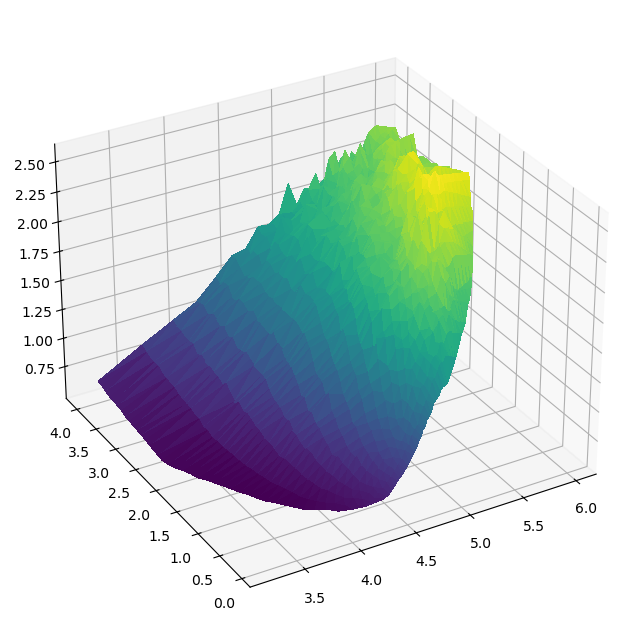

In [6]:
# Monte Carlo Simulation
leverageFct = ql.HestonSLVMCModel(
    localVol, hestonModel, ql.MTBrownianGeneratorFactory(1234), exerciseDate, 91
).leverageFunction()


# Plot the Leverage Function
tSteps = 40
uSteps = 30

tv = np.linspace(0.1, dc.yearFraction(settlementDate, exerciseDate), tSteps)

t = np.zeros(tSteps * uSteps)
s = np.zeros(tSteps * uSteps)
z = np.zeros(tSteps * uSteps)

for i in range(tSteps):
    scale = min(4, math.exp(3 * math.sqrt(tv[i]) * vol))
    sv = np.linspace(spot / scale, spot * scale, uSteps)

    for j in range(uSteps):
        idx = i * uSteps + j
        t[idx] = tv[i]
        s[idx] = math.log(sv[j])
        z[idx] = leverageFct.localVol(t[idx], sv[j])


fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection="3d")

surf = ax.plot_trisurf(s, t, z, cmap=plt.cm.viridis, linewidth=0, antialiased=False, edgecolor="none")
ax.view_init(30, -120)